In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from copy import copy

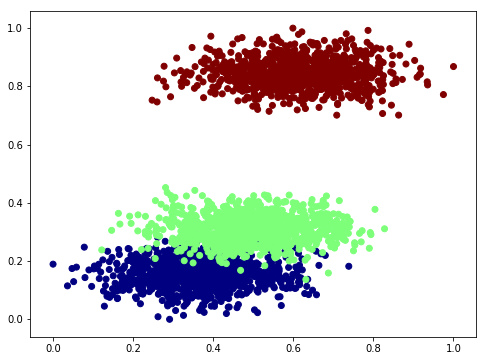

In [24]:
d = 2
k = 3
num = 1000

x = []
y = []
for i in np.arange(k):
    x.append(np.random.randn(num,d) + 8 * np.random.randn(1, d))
    y.append([i]*num)

y = np.hstack(y)
x = np.vstack(x)

x_max = np.max(x, axis = 0)
x_min = np.min(x, axis = 0)

x -= x_min
x /= (x_max - x_min)


plt.figure(figsize=(8,6))
plt.scatter(x[:,0], x[:,1], c = y, cmap = 'jet')


In [25]:
def Mode(x, axis=0):
    return mode(x, axis).mode

In [26]:
def Gini(y):
    sum = 0
    for i in np.unique(y):
        sum += len(y[y==i])/len(y) * (1 - len(y[y==i])/len(y))    
    return sum

def IG(y, x_k, t, error_func):
    n = len(y)
    l = x_k<t
    return error_func(y) - (len(y[l])/n * error_func(y[l]) + (len(y[~l])/n * error_func(y[~l])))


In [27]:
def GetThreshold(x, y, error_func, num, features = None):
#     num = np.linspace(x.min(), x.max(), num = num)
    gain = []
    if features is None:
        features = np.arange(x.shape[1])
        
    for k in features:
        row = []
        for i in np.linspace(x[:,k].min(), x[:,k].max(), num=num):
            row.append(IG(y, x[:,k], i, error_func))
        gain.append(np.array(row))
    gain = np.vstack(gain)
    gain[np.isnan(gain)] = -np.inf
    k_ind, i = np.unravel_index(np.argmax(gain, axis = None), gain.shape)
    k_out = features[k_ind]
    t = np.linspace(x[:,k_out].min(), x[:, k_out].max(), num=num)[i]

    return k_out, t, gain[k_ind,i]
#gain[k, i]

In [28]:
class Tree:
    def __init__(self, error_func, agg_func, max_depth=5, gain_threshold=1e-2, num=50):
        
        self.error_func = error_func
        self.agg_func = agg_func
        self.max_depth = max_depth
        self.gain_threshold = gain_threshold
        self.num = num
    
    
    def fit(self, x, y, features = None):
        self.k, self.split_threshold, self.gain = GetThreshold(x, y, self.error_func, self.num, features)
#         print(self.split_threshold)
#         ig = IG(y, x[:,self.k], self.split_threshold, error_func)
        left = x[:,self.k]<self.split_threshold
        if self.max_depth > 0 and self.gain > self.gain_threshold:
            self.left = Tree(self.error_func, self.agg_func, self.max_depth - 1, self.gain_threshold)
            self.left.fit(x[left, :], y[left], features)
            self.right = Tree(self.error_func, self.agg_func, self.max_depth - 1, self.gain_threshold)
            self.right.fit(x[~left, :], y[~left], features)
            self.leaf = False
        else:
            self.values = self.agg_func(y)
            self.leaf = True
        
    
    def predict(self, x):
        y_hat = np.ones(x.shape[0])
        if self.leaf:
            y_hat = self.values
        
        else:
            left = x[:,self.k] < self.split_threshold
            y_hat[left] = self.left.predict(x[left])
            y_hat[~left] = self.right.predict(x[~left])
        return y_hat
    
    def Interpret(self):
        if not self.leaf:
            left_ks, left_gains = self.left.Interpret()
            right_ks, right_gains =self.right.Interpret()
            print(left_gains)
            
            gains = np.hstack([np.array(self.gain), left_gains, right_gains])
            ks = np.hstack([np.array(self.k),left_ks, right_ks])
            
#             sort_ind = np.argsort(gains)[::-1]
#             print(self.k)
            
            return ks, gains
        
        else:
            return np.array([]), np.array([])
    
    def PtintInterpret(self, depth = 0, side = 'Root'):
        if not self.leaf:
            print('{}{}'.format('  '*depth, side))
            print('{}k: {}'.format('  '*(depth+1)+' ', self.k))
            print('{}gain: {}'.format('  '*(depth+1)+ ' ', self.gain))
            
            self.left.PtintInterpret(depth+1, 'Left')
            self.right.PtintInterpret(depth+1, 'Right')
            
            

In [29]:
tree = Tree(Gini, Mode)

In [30]:
tree.fit(x,y)

In [31]:
y_hat = tree.predict(x)

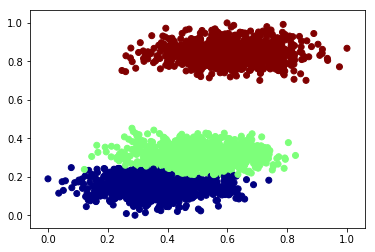

In [32]:
plt.scatter(x[:,0], x[:,1], c=y_hat, cmap='jet')

In [33]:
x = np.random.rand(1000,1) * 5 - 2.5
y = x ** 5 - 8* x ** 3 + 10 * x + 6 + np.random.randn(x.shape[0],1)

In [34]:
y = y.reshape(-1,)

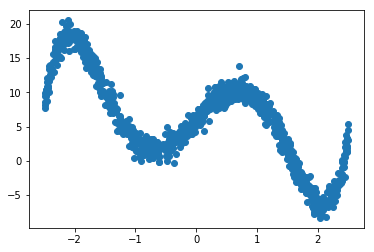

In [35]:
plt.scatter(x,y)

In [36]:
tree1 = Tree(np.var, np.mean, max_depth=3)

In [37]:
tree1.fit(x,y)
y_hat = tree1.predict(x)

In [38]:
y_hat.shape

(1000,)

In [39]:
resid = y - y_hat

In [40]:
resid.shape

(1000,)

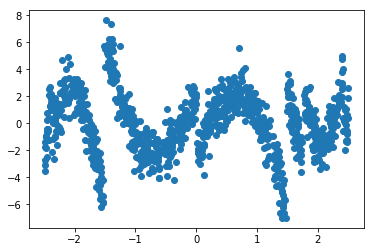

In [41]:
plt.scatter(x, resid)

In [42]:
tree2 = Tree(np.var, np.mean, max_depth=3)

In [43]:
tree2.fit(x, resid)
y_hat2 = tree2.predict(x)

In [44]:
resid2 = resid - y_hat2

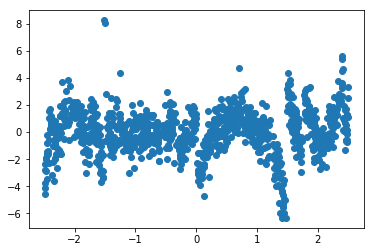

In [45]:
plt.scatter(x, resid2)

In [78]:
class Boosting:
    def __init__(self, root_tree, num_tree):
        self.root_tree = root_tree
        self.num_tree = num_tree
        
    def fit(self, x, y):
        resid = y
        self.trees = []
        for i in range(self.num_tree):
            # use copy to copy a new tree
            tree = copy(self.root_tree)
            tree.fit(x, resid)
            resid_hat = tree.predict(x)
            resid = resid - resid_hat
            self.trees.append(tree)
            
    def predict(self, x):
        y_hat = np.zeros(x.shape[0])
        for tree in self.trees:
            y_hat += tree.predict(x)
#             print(y_hat)
        return y_hat
    

In [60]:
trees = []
resid = y
for i in range(10):
    tree = Tree(np.var, np.mean, max_depth=3)
    tree.fit(x, resid)
    resid_hat = tree.predict(x)
    resid = resid - resid_hat
    trees.append(tree)

In [48]:
y_hat = np.zeros(y.shape)

for tree in trees:
    y_hat += tree.predict(x)

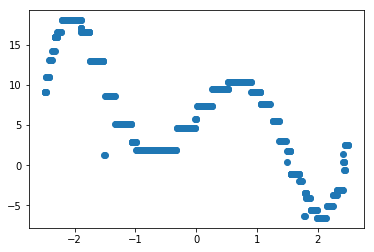

In [49]:
plt.scatter(x, y_hat)

In [79]:
boost = Boosting(Tree(np.var, np.mean, max_depth=3), 10)

In [80]:
boost.fit(x, y)

In [81]:
y_hat = boost.predict(x)

In [84]:
y_hat.shape

(1000,)

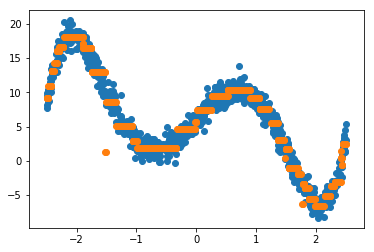

In [83]:
plt.scatter(x, y)
plt.scatter(x, y_hat)

## Gradient Boosting

In [96]:
class GradientBoosting:
    def __init__(self, root_tree, num_tree, learn_rate=1e-5, iteration=10):
        self.root_tree = root_tree
        self.num = num_tree
        self.learn_rate = learn_rate
        self.iteration = iteration
    
    def fit(self, x, y):
        self.gammas = []
        self.trees = []
        
        y_hat = np.zeros(x.shape[0])
        for i in range(5):
            resid = y - y_hat
            tree = copy(self.root_tree)
            tree.fit(x, resid)

            gamma = 1
            for j in range(iteration):
                resid_hat = tree.predict(x)
                y_hat_new = y_hat + gamma * resid_hat
                grad = -2 * np.sum((y-y_hat_new) * resid_hat) / x.shape[0]
                gamma -= learn_rate * grad

            self.gammas.append(gamma)
#             plt.scatter(x, resid)
#             plt.scatter(x, resid_hat)
#             plt.show()
            y_hat += gamma * resid_hat      
            self.trees.append(tree)
        
    def predict(self, x):
        y_hat = np.zeros(x.shape[0])
        
        for i, tree in enumerate(self.trees):
            resid_hat = tree.predict(x)
            y_hat += resid_hat * self.gammas[i]
        return y_hat
        

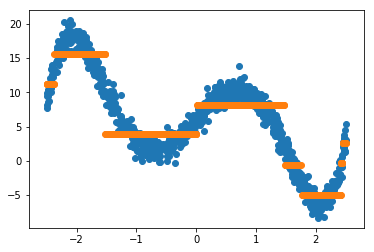

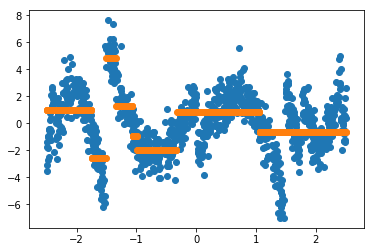

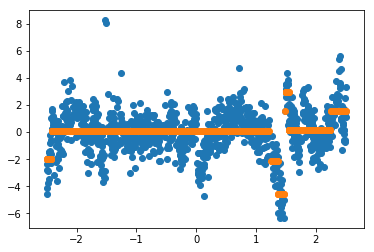

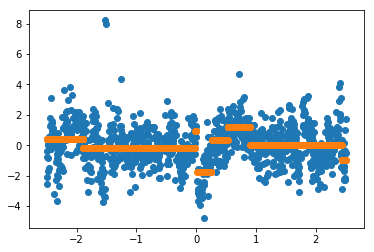

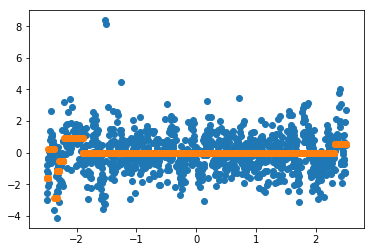

In [90]:
trees = []
resid = y
gammas = []
iteration = 10
learn_rate = 1e-5
y_hat = np.zeros(x.shape[0])

for i in range(5):
    tree = Tree(np.var, np.mean, max_depth=3)
    tree.fit(x, resid)
    
    gamma = 1
    for j in range(iteration):
        resid_hat = tree.predict(x)
        y_hat_new = y_hat + gamma * resid_hat
        grad = -2 * np.sum((y-y_hat_new) * resid_hat) / x.shape[0]
        gamma -= learn_rate * grad

    gammas.append(gamma)
    plt.scatter(x, resid)
    plt.scatter(x, resid_hat)
    plt.show()
    y_hat += gamma * resid_hat    
    resid = y - y_hat       
    trees.append(tree)
    

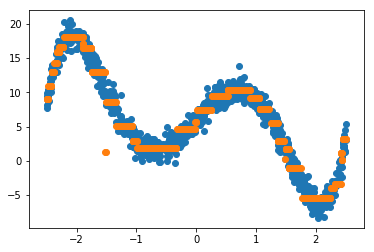

In [91]:
plt.scatter(x,y)
plt.scatter(x,y_hat)

In [97]:
gb = GradientBoosting(Tree(np.var, np.mean, max_depth=3), 5)


In [98]:
gb.fit(x,y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [99]:
y_hat = gb.predict(x)

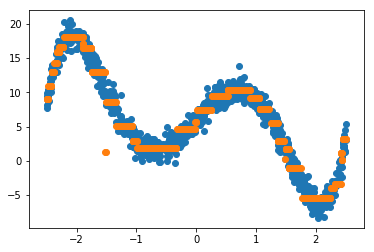

In [101]:
plt.scatter(x,y)
plt.scatter(x,y_hat)

In [105]:
x_line = np.linspace(-5,5, num=200).reshape(-1,1)

In [106]:
y_line = gb.predict(x_line)

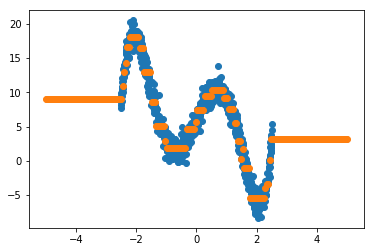

In [107]:
plt.scatter(x,y)
plt.scatter(x_line, y_line)